<a href="https://colab.research.google.com/github/suponinskii/classification_plants_deseases/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%94%D0%B8%D0%BF%D0%BB%D0%BE%D0%BC%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%22%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B7%D0%B0%D0%B1%D0%BE%D0%BB%D0%B5%D0%B2%D0%B0%D0%BD%D0%B8%D0%B9_%D1%80%D0%B0%D1%81%D1%82%D0%B5%D0%BD%D0%B8%D0%B9%22%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Я напишу нейронную сеть которая по фотографии любого размера будет распознавать заболевания, имеющиеся в базе. Сперва научу нейросеть на винограде, а после дообучаю на оставшейся базе. Сохранив веса и параметры, в будущем хотелось бы её ещё дообучать на других растениях. В идеале это должно работать следующим образом: выбираешь растение, делаешь фотку на телефоне, и программа выдаёт тебе заболевание/его отсутствие и процент точности (в случае если будет 50? % и ниже - неизвестное заболевание/перефоткать)

In [3]:
import numpy as np #Библиотека работы с массивами
import pandas as pd # Библиотека для работы с базами

from tensorflow.keras.models import Sequential, Model # 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D #
from tensorflow.keras import utils #Используем для to_categoricall
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop #
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence #
from tensorflow.keras.preprocessing.sequence import pad_sequences #
from tensorflow.keras.callbacks import LambdaCallback # подключаем колбэки

from sklearn.preprocessing import StandardScaler # 
from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error #
from google.colab import files #Для загрузки своей картинки

import random #Для генерации случайных чисел 
import math # Для округления
import os #Для работы с файлами 
import re #
import matplotlib.pyplot as plt #
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline


In [ ]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator # Работа с изображениями
from tensorflow.keras.preprocessing import image # Для отрисовки изображений
import numpy as np                               # Библиотека работы с массивами
from PIL import Image                            # Для отрисовки изображений
import cv2
import tensorflow as tf



In [ ]:
from google.colab import drive # Подключаем диск
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
validation_data_dir = '/content/drive/MyDrive/Grape/valid'  

In [ ]:
train_data_dir = '/content/drive/MyDrive/Grape/train'  
validation_data_dir = '/content/drive/MyDrive/Grape/valid'  
target_names = [item for item in os.listdir(train_data_dir) if os.path.isdir(os.path.join(train_data_dir, item))]
nb_train_samples = sum([len(files) for _, _, files in os.walk(train_data_dir)])  
nb_validation_samples = sum([len(files) for _, _, files in os.walk(validation_data_dir)])
total_nb_samples = nb_train_samples + nb_validation_samples 
nb_classes = len(target_names)      # number of output classes

print('Training a CNN Multi-Classifier Model ......')
print('\n - names of classes: ', target_names, '\n - of classes: ', nb_classes)
print(' - of trained samples: ', nb_train_samples, '\n - of validation samples: ', nb_validation_samples,
       '\n - total of samples: ', total_nb_samples)

Training a CNN Multi-Classifier Model ......

 - names of classes:  ['Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Grape___Black_rot'] 
 - of classes:  4
 - of trained samples:  8217 
 - of validation samples:  79 
 - total of samples:  8296


In [ ]:
batch_size = 150  # Размер выборки
img_width = 128  # Ширина изображения *2
img_height = 128 # Высота изображения

In [ ]:
# Генератор изображений
datagen = ImageDataGenerator(
    rescale=1. / 255,       # Значения цвета меняем на дробные показания
    rotation_range=10,      # Поворачиваем изображения при генерации выборки
    width_shift_range=0.1,  # Двигаем изображения по ширине при генерации выборки
    height_shift_range=0.1, # Двигаем изображения по высоте при генерации выборки
    zoom_range=0.1,         # Зумируем изображения при генерации выборки
    horizontal_flip=False,   # Отключаем отзеркаливание изображений
    fill_mode='nearest',    # Заполнение пикселей вне границ ввода
    validation_split=0.2    # Указываем разделение изображений на обучающую и тестовую выборку
)

In [ ]:
# Обучающая выборка
train_generator = datagen.flow_from_directory(
    train_data_dir,                          # Путь ко всей выборке выборке
    target_size=(img_width, img_height), # Размер изображений
    batch_size=batch_size,               # Размер batch_size
    class_mode='categorical',            # Категориальный тип выборки. Разбиение выборки по болезням
    shuffle=True,                        # Перемешивание выборки
    subset='training'                    # устанавливаем как набор для обучения
)

# Проверочная выборка
validation_generator = datagen.flow_from_directory(
    train_data_dir,                          # Путь ко всей выборке выборке
    target_size=(img_width, img_height), # Размер изображений
    batch_size=batch_size,               # Размер batch_size
    class_mode='categorical',            # Категориальный тип выборки. Разбиение выборки по болезням
    shuffle=True,                        # Перемешивание выборки
    subset='validation' 
)                                        # Устанавливаем как валидационный набор


Found 6575 images belonging to 4 classes.
Found 1642 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.preprocessing import image # Для отрисовки изображений

In [ ]:
# Выводим для примера картинки по каждому классу
fig, axs = plt.subplots(1, 4, figsize=(25, 5)) # Создаем полотно из 3 графиков
for i in range(4):                             # Проходим по всем классам
  grape_path = train_data_dir + '/' + os.listdir(train_data_dir)[i] + '/' # Формируем путь к выборке
  img_path = grape_path + random.choice(os.listdir(grape_path))     # Выбираем случайное фото для отображения 
  axs[i].imshow(image.load_img(img_path, target_size=(img_height, img_width))) # Отображение фотографии

plt.show() # Выводим изображения

NameError: ignored

In [ ]:
model = Sequential ()
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(img_width, img_height, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation = 'relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(4, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 42, 42, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 42, 42, 64)       

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=20,
    verbose=1)

Epoch 1/20
43/43 [==============================] - 1442s 34s/step - loss: 0.5973 - accuracy: 0.8056 - val_loss: 2.9324 - val_accuracy: 0.2073
Epoch 2/20
43/43 [==============================] - 57s 1s/step - loss: 0.2561 - accuracy: 0.9063 - val_loss: 5.7092 - val_accuracy: 0.2060
Epoch 3/20
43/43 [==============================] - 57s 1s/step - loss: 0.1750 - accuracy: 0.9377 - val_loss: 7.8196 - val_accuracy: 0.2033
Epoch 4/20
43/43 [==============================] - 57s 1s/step - loss: 0.1276 - accuracy: 0.9549 - val_loss: 9.5219 - val_accuracy: 0.2113
Epoch 5/20
43/43 [==============================] - 57s 1s/step - loss: 0.1034 - accuracy: 0.9631 - val_loss: 11.8107 - val_accuracy: 0.2100
Epoch 6/20
43/43 [==============================] - 57s 1s/step - loss: 0.0879 - accuracy: 0.9695 - val_loss: 11.7837 - val_accuracy: 0.3207
Epoch 7/20
43/43 [==============================] - 57s 1s/step - loss: 0.0853 - accuracy: 0.9690 - val_loss: 12.0953 - val_accuracy: 0.3667
Epoch 8/20
43/

In [ ]:
model.save_weights('/content/drive/MyDrive/Grape/model100.h5')

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=10,
    verbose=1)

In [ ]:
#Оображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

По графику мы видим что нейронная сеть может определять заболевание с довольно высокой точностью (вплоть до 99%).
Проверим на фотографиях, которые нейронная сеть ещё не видела

In [ ]:
model_weight = '/content/drive/MyDrive/Grape/model100.h5'
model.load_weights(model_weight) 

In [ ]:
test_generator = datagen.flow_from_directory(
    validation_data_dir,                          # Путь ко всей выборке выборке
    target_size=(img_width, img_height), # Размер изображений
    batch_size=batch_size,               # Размер batch_size
    class_mode='categorical',            # Категориальный тип выборки. Разбиение выборки по болезням
    shuffle=True)                        # Перемешивание выборки                  

Found 79 images belonging to 4 classes.


In [ ]:
from keras.preprocessing import image

In [ ]:
def prepare(img_path):
    img = image.load_img(img_path, target_size=(128,128, 3))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)

In [ ]:
classes = list (test_generator.class_indices)

In [ ]:
test_images = []
for i in range(4): 
  test_images.extend (os.listdir(validation_data_dir + '/' + classes[i])) 

In [ ]:
test_images

In [ ]:
  result = model.predict([prepare('/content/drive/MyDrive/Grape/valid/Grape___Black_rot/fc4a5f21-0d08-479d-b506-2d5eae6d0ac1___FAM_B.Rot 3358.JPG')])
  disease=image.load_img('/content/drive/MyDrive/Grape/valid/Grape___Black_rot/fc4a5f21-0d08-479d-b506-2d5eae6d0ac1___FAM_B.Rot 3358.JPG')
  plt.imshow(disease)
  classresult=np.argmax(result,axis=1)
  print('Prediction:', classes[classresult[0]])
  print('Real:')

Prediction: Grape___Black_rot
Real:


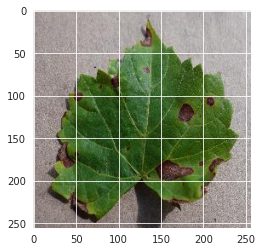

In [ ]:
result = model.predict([prepare('/content/drive/MyDrive/Grape/valid/Grape___Black_rot/fc4a5f21-0d08-479d-b506-2d5eae6d0ac1___FAM_B.Rot 3358.JPG')])

disease=image.load_img('/content/drive/MyDrive/Grape/valid/Grape___Black_rot/fc4a5f21-0d08-479d-b506-2d5eae6d0ac1___FAM_B.Rot 3358.JPG')
plt.imshow(disease)
classresult=np.argmax(result,axis=1)
print('Prediction:', classes[classresult[0]])
print('Real:')

In [ ]:
def predict_image():
  result = model.predict ([prepare (img_path)])
  disease=image.load_img(img_path)
  plt.imshow(disease)
  classresult=np.argmax(result,axis=1)
  print('Prediction:', classes[classresult[0]])
  print('Real:', classes)